In [1]:
import ssl
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_cosine_schedule_with_warmup
import os
from PIL import Image
from transformers import CLIPTokenizer
import torch.nn.functional as F
from tqdm import tqdm

cuda_device = "cuda:0"  

ssl._create_default_https_context = ssl._create_unverified_context

class RobustCustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(128, 128)):
        self.root_dir = root_dir
        self.image_paths = []
        
        for f in os.listdir(root_dir):
            if f.endswith(('.jpg', '.png')): 
                path = os.path.join(root_dir, f)
                try:
                    with Image.open(path) as img:
                        img.verify() 
                    self.image_paths.append(path)
                except Exception as e:
                    print(f"Skipped corrupted file: {path}, error: {str(e)}")
        
        self.transform = transform or transforms.Compose([ 
            transforms.Resize(target_size), 
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
        ])

    def __len__(self): 
        return len(self.image_paths)

    def __getitem__(self, idx): 
        path = self.image_paths[idx]
        try:
            img = Image.open(path).convert("RGB")
            return self.transform(img)
        except Exception as e:
            print(f"Error loading {path}: {str(e)}")
            return None  

def collate_fn(batch): 
    batch = [b for b in batch if b is not None]
    return torch.utils.data.dataloader.default_collate(batch)

dataset = RobustCustomDataset(r"dataset/Open_circuit")
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

pretrained_model = "stabilityai/stable-diffusion-2-base"
pipe = StableDiffusionPipeline.from_pretrained(pretrained_model, torch_dtype=torch.float32)  
pipe = pipe.to(cuda_device)

pipe.text_encoder.eval()  
pipe.vae.eval()
unet = pipe.unet
unet.train()  

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-6)

num_epochs = 30
best_loss = float('inf')

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for step, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        if batch is None or batch.shape[0] == 0:
            continue
            
        images = batch.to(cuda_device, dtype=torch.float32)  
        
        text_input = ["Open_circuit"] * images.shape[0]
        input_ids = tokenizer(text_input, padding=True, truncation=True, return_tensors="pt").input_ids.to(cuda_device)
        
        encoder_hidden_states = pipe.text_encoder(input_ids).last_hidden_state
        
        latents = pipe.vae.encode(images).latent_dist.sample()
        latents = latents * pipe.vae.config.scaling_factor  
        
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, pipe.scheduler.num_train_timesteps, (latents.shape[0],)).long().to(cuda_device)
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
        
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample
        
        loss = F.mse_loss(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        pipe.save_pretrained("./pcb_ldm_finetuned_Open_circuit_best")
        print(f"New best model saved with loss: {best_loss:.4f}")

pipe.save_pretrained("./pcb_ldm_finetuned_Open_circuit")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/241 [00:00<?, ?it/s]c:\Users\vipuser\anaconda3\Lib\site-packages\transformers\models\clip\modeling_clip.py:539: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\vipuser\anaconda3\Lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'PNDMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/30: 100%|██████████| 241/241 [01:18<00:00,  3.09it/s]


Epoch 1/30, Avg Loss: 0.1450
New best model saved with loss: 0.1450


Epoch 2/30: 100%|██████████| 241/241 [01:17<00:00,  3.12it/s]


Epoch 2/30, Avg Loss: 0.1322
New best model saved with loss: 0.1322


Epoch 3/30: 100%|██████████| 241/241 [01:14<00:00,  3.22it/s]


Epoch 3/30, Avg Loss: 0.1083
New best model saved with loss: 0.1083


Epoch 4/30: 100%|██████████| 241/241 [01:15<00:00,  3.17it/s]


Epoch 4/30, Avg Loss: 0.1126


Epoch 5/30: 100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


Epoch 5/30, Avg Loss: 0.1202


Epoch 6/30: 100%|██████████| 241/241 [01:15<00:00,  3.20it/s]


Epoch 6/30, Avg Loss: 0.1132


Epoch 7/30: 100%|██████████| 241/241 [01:16<00:00,  3.16it/s]


Epoch 7/30, Avg Loss: 0.1136


Epoch 8/30: 100%|██████████| 241/241 [01:15<00:00,  3.19it/s]


Epoch 8/30, Avg Loss: 0.1079
New best model saved with loss: 0.1079


Epoch 9/30: 100%|██████████| 241/241 [01:15<00:00,  3.17it/s]


Epoch 9/30, Avg Loss: 0.1130


Epoch 10/30: 100%|██████████| 241/241 [01:14<00:00,  3.21it/s]


Epoch 10/30, Avg Loss: 0.1108


Epoch 11/30: 100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


Epoch 11/30, Avg Loss: 0.1043
New best model saved with loss: 0.1043


Epoch 12/30: 100%|██████████| 241/241 [01:15<00:00,  3.19it/s]


Epoch 12/30, Avg Loss: 0.1072


Epoch 13/30: 100%|██████████| 241/241 [01:14<00:00,  3.25it/s]


Epoch 13/30, Avg Loss: 0.1087


Epoch 14/30: 100%|██████████| 241/241 [01:14<00:00,  3.22it/s]


Epoch 14/30, Avg Loss: 0.1131


Epoch 15/30: 100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


Epoch 15/30, Avg Loss: 0.1056


Epoch 16/30: 100%|██████████| 241/241 [01:15<00:00,  3.20it/s]


Epoch 16/30, Avg Loss: 0.1043


Epoch 17/30: 100%|██████████| 241/241 [01:14<00:00,  3.22it/s]


Epoch 17/30, Avg Loss: 0.1131


Epoch 18/30: 100%|██████████| 241/241 [01:15<00:00,  3.20it/s]


Epoch 18/30, Avg Loss: 0.1091


Epoch 19/30: 100%|██████████| 241/241 [01:14<00:00,  3.24it/s]


Epoch 19/30, Avg Loss: 0.1147


Epoch 20/30: 100%|██████████| 241/241 [01:14<00:00,  3.23it/s]


Epoch 20/30, Avg Loss: 0.1064


Epoch 21/30: 100%|██████████| 241/241 [01:14<00:00,  3.21it/s]


Epoch 21/30, Avg Loss: 0.0976
New best model saved with loss: 0.0976


Epoch 22/30: 100%|██████████| 241/241 [01:14<00:00,  3.24it/s]


Epoch 22/30, Avg Loss: 0.0967
New best model saved with loss: 0.0967


Epoch 23/30: 100%|██████████| 241/241 [01:15<00:00,  3.19it/s]


Epoch 23/30, Avg Loss: 0.1000


Epoch 24/30: 100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


Epoch 24/30, Avg Loss: 0.1088


Epoch 25/30: 100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


Epoch 25/30, Avg Loss: 0.1012


Epoch 26/30: 100%|██████████| 241/241 [01:15<00:00,  3.20it/s]


Epoch 26/30, Avg Loss: 0.1005


Epoch 27/30: 100%|██████████| 241/241 [01:14<00:00,  3.23it/s]


Epoch 27/30, Avg Loss: 0.1081


Epoch 28/30: 100%|██████████| 241/241 [01:14<00:00,  3.23it/s]


Epoch 28/30, Avg Loss: 0.0940
New best model saved with loss: 0.0940


Epoch 29/30: 100%|██████████| 241/241 [01:15<00:00,  3.20it/s]


Epoch 29/30, Avg Loss: 0.1143


Epoch 30/30: 100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


Epoch 30/30, Avg Loss: 0.1041


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\vipuser\anaconda3\Lib\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

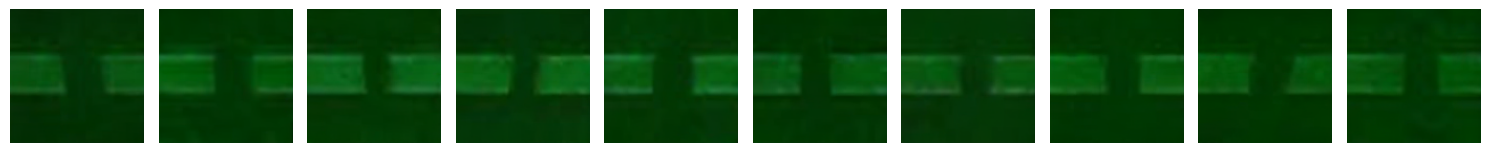

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

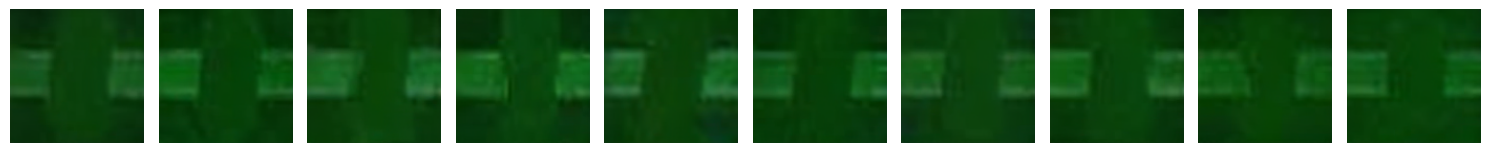

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

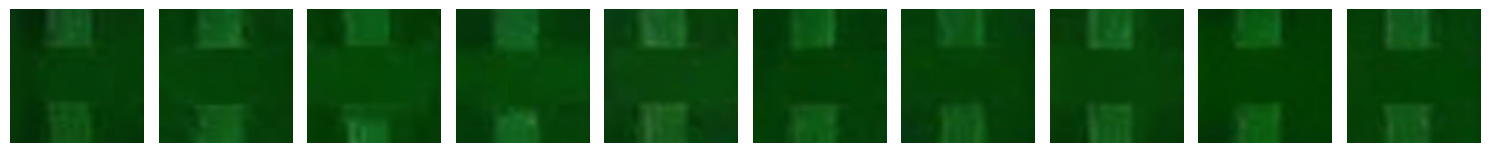

In [1]:
import torch
from PIL import Image
from torchvision import transforms
from diffusers import StableDiffusionImg2ImgPipeline
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the device here
device = "cuda:1"  # Change this to "cuda:1", "cuda:2", or "cpu" as needed

model_path = "./pcb_ldm_finetuned_Open_circuit_best"

# Ensure the pipeline uses the specified device
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float32,
    safety_checker=None
).to(device)

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((128, 128))
    return image

# List of image paths
input_image_paths = [
    r"dataset\Open_circuit\Open_circuit_01_open_circuit_01_1071_1342_1113_1380.jpg",
    r"dataset\Open_circuit\Open_circuit_01_open_circuit_03_599_909_633_942.jpg", 
    r"dataset\Open_circuit\Open_circuit_01_open_circuit_04_728_1278_762_1315.jpg", 
]

# Loop over the list of image paths
for input_image_path in input_image_paths:
    input_image = preprocess_image(input_image_path)

    image_name = os.path.splitext(os.path.basename(input_image_path))[0]
    folder_path = os.path.join(os.getcwd(), "test_create_Open_circuit", image_name)
    os.makedirs(folder_path, exist_ok=True)

    origin_path = os.path.join(folder_path, "origin.png")
    input_image.save(origin_path)

    strength = 0.2
    num_images = 10
    guidance_scale = 10
    num_inference_steps = 50

    # Ensure generators are on the specified device
    generators = [torch.Generator(device=device).manual_seed(i) for i in range(100, 100 + num_images)]
    generated_images = []

    for i in range(num_images):
        result = pipe(
            prompt="Open_circuit",
            image=input_image,
            strength=strength,
            guidance_scale=guidance_scale,
            generator=generators[i],
            num_inference_steps=num_inference_steps
        )
        generated_image = result.images[0]
        generated_image.save(os.path.join(folder_path, f"create{i+1}.png"))
        generated_images.append(generated_image)

    # Display the generated images for the current image in the list
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from diffusers import StableDiffusionImg2ImgPipeline
device='cuda:1'
# 初始化模型管道
model_path = "./pcb_ldm_finetuned_Open_circuit_best"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float32,
    safety_checker=None
).to(device)

# 配置参数
NUM_VARIANTS = 5                  # 每个样本生成数量
OUTPUT_DIR = r"images/Open_circuit_create"  # 输出目录
XML_DIR = r"Annotations\Open_circuit"     # XML文件目录（需替换为实际路径）
IMAGE_SIZE = (128, 128)           # 模型输入尺寸
GEN_STRENGTH = 0.2               # 生成强度
GEN_GUIDANCE = 10                # 引导系数
GEN_STEPS = 50                    # 生成步数

def parse_xml(xml_path):
    """解析XML文件获取图像信息和标注框"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # 获取图像元数据
    filename = root.find('filename').text
    img_path = root.find('path').text
    size = {
        'width': int(root.find('size/width').text),
        'height': int(root.find('size/height').text)
    }
    
    # 提取所有标注框
    bndboxes = []
    for obj in root.findall('object'):
        box = obj.find('bndbox')
        bndboxes.append((
            int(box.find('xmin').text),
            int(box.find('ymin').text),
            int(box.find('xmax').text),
            int(box.find('ymax').text)
        ))
    
    return filename, img_path, size, bndboxes

def process_image(original_img, bndboxes, variant_num):
    """处理单个图像生成变体"""
    # 创建图像副本
    new_img = original_img.copy()
    
    for xmin, ymin, xmax, ymax in bndboxes:
        # 裁剪目标区域
        crop_img = original_img.crop((xmin, ymin, xmax, ymax))
        
        # 调整到模型输入尺寸
        input_img = crop_img.resize(IMAGE_SIZE)
        
        # 生成增强图像
        generator = torch.Generator(device=device).manual_seed(100 + variant_num)
        result = pipe(
            prompt="Open_circuit",
            image=input_img,
            strength=GEN_STRENGTH,
            guidance_scale=GEN_GUIDANCE,
            generator=generator,
            num_inference_steps=GEN_STEPS
        )
        
        # 调整回原始标注框尺寸
        generated = result.images[0].resize((xmax-xmin, ymax-ymin))
        
        # 替换到新图像
        new_img.paste(generated, (xmin, ymin))
    
    return new_img

def main():
    # 创建输出目录
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print("*")
    # 遍历所有XML文件
    for xml_path in glob.glob(os.path.join(XML_DIR, "*.xml")):
        # 解析XML文件
        filename, img_path, size, bndboxes = parse_xml(xml_path)
        print(img_path)
        # 加载原始图像
        try:
            original_img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"警告：未找到图像文件 {img_path}")
            continue
        
        # 生成所有变体
        base_name = os.path.splitext(filename)[0]
        for i in range(1, NUM_VARIANTS+1):
            # 处理生成图像
            new_img = process_image(original_img, bndboxes, i)
            
            # 保存结果
            output_path = os.path.join(
                OUTPUT_DIR, 
                f"{base_name}_create_{i}.jpg"
            )
            new_img.save(output_path)
            print(f"已生成：{output_path}")


main()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

*
images/Open_circuit/01_open_circuit_01.jpg


c:\Users\vipuser\anaconda3\Lib\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_01_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_01_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_01_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_01_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_01_create_5.jpg
images/Open_circuit/01_open_circuit_02.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_02_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_02_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_02_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_02_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_02_create_5.jpg
images/Open_circuit/01_open_circuit_03.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_03_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_03_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_03_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_03_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_03_create_5.jpg
images/Open_circuit/01_open_circuit_04.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_04_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_04_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_04_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_04_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_04_create_5.jpg
images/Open_circuit/01_open_circuit_05.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_05_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_05_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_05_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_05_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_05_create_5.jpg
images/Open_circuit/01_open_circuit_06.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_06_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_06_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_06_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_06_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_06_create_5.jpg
images/Open_circuit/01_open_circuit_07.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_07_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_07_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_07_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_07_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_07_create_5.jpg
images/Open_circuit/01_open_circuit_08.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_08_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_08_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_08_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_08_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_08_create_5.jpg
images/Open_circuit/01_open_circuit_09.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_09_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_09_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_09_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_09_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_09_create_5.jpg
images/Open_circuit/01_open_circuit_10.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_10_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_10_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_10_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_10_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_10_create_5.jpg
images/Open_circuit/01_open_circuit_11.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_11_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_11_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_11_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_11_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_11_create_5.jpg
images/Open_circuit/01_open_circuit_12.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_12_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_12_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_12_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_12_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_12_create_5.jpg
images/Open_circuit/01_open_circuit_13.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_13_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_13_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_13_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_13_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_13_create_5.jpg
images/Open_circuit/01_open_circuit_14.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_14_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_14_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_14_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_14_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_14_create_5.jpg
images/Open_circuit/01_open_circuit_15.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_15_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_15_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_15_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_15_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_15_create_5.jpg
images/Open_circuit/01_open_circuit_16.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_16_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_16_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_16_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_16_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_16_create_5.jpg
images/Open_circuit/01_open_circuit_17.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_17_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_17_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_17_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_17_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_17_create_5.jpg
images/Open_circuit/01_open_circuit_18.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_18_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_18_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_18_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_18_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_18_create_5.jpg
images/Open_circuit/01_open_circuit_19.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_19_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_19_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_19_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_19_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_19_create_5.jpg
images/Open_circuit/01_open_circuit_20.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_20_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_20_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_20_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_20_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\01_open_circuit_20_create_5.jpg
images/Open_circuit/04_open_circuit_01.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_01_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_01_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_01_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_01_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_01_create_5.jpg
images/Open_circuit/04_open_circuit_02.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_02_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_02_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_02_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_02_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_02_create_5.jpg
images/Open_circuit/04_open_circuit_03.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_03_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_03_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_03_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_03_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_03_create_5.jpg
images/Open_circuit/04_open_circuit_04.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_04_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_04_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_04_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_04_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_04_create_5.jpg
images/Open_circuit/04_open_circuit_05.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_05_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_05_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_05_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_05_create_4.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_05_create_5.jpg
images/Open_circuit/04_open_circuit_06.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_06_create_1.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_06_create_2.jpg


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

已生成：images/Open_circuit_create\04_open_circuit_06_create_3.jpg


  0%|          | 0/10 [00:00<?, ?it/s]